In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="darkgrid")
from datetime import datetime
import cvxpy as cp  
import scipy.optimize as sco
import numpy as np
#from arch import arch_model
#import empyrical as ep
from sklearn.covariance import LedoitWolf, MinCovDet
from pandas_datareader import data as wb
import time

In [ ]:
X=np.load("/content/drive/MyDrive/NIFTY 50 Dataset/Processed Data/X_1200.npy")
rb=np.load("/content/drive/MyDrive/NIFTY 50 Dataset/Processed Data/rb_1200.npy")

In [ ]:
X.shape

(1200, 49)

In [ ]:
rb.shape

(1200,)

In [ ]:
where_X_is_NaN=np.isnan(X)
where_rb_is_NaN=np.isnan(rb)

In [ ]:
#where_X_is_valid=np.logical_not(where_X_is_NaN)
#where_rb_is_valid=np.logical_not(where_rb_is_NaN)
X[where_X_is_NaN]=0
rb[where_rb_is_NaN]=0

T_test is the time period we want to hold the portfolio for.

In [ ]:
T=X.shape[0]
N=X.shape[1]
Aniket=0.5 #Aniket decides the proportion of Train data to Test Data

T_start=0
T_test= 240 #Decides the time we hold the portfolio for.
T_train=int(Aniket*T_test)

X_train=X[T_start+T_test:T_start+T_test+T_train,:]
X_test=X[T_start:T_start+T_test,:]
X_train=np.flip(X_train)
X_test=np.flip(X_test)
rb_train=rb[T_start+T_test:T_start+T_test+T_train]
rb_test=rb[T_start:T_start+T_test]
rb_train=np.flip(rb_train)
rb_test=np.flip(rb_test)

In [ ]:
#len(X_train)

In [ ]:
# L1=(X_train.T @ X_train)
# print(L1.shape)
# lambda_L1=np.linalg.eigh(L1)[0]
# lambda_L1_max=np.max(lambda_L1)
# I=np.identity(L1.shape[0])
# M=lambda_L1_max*I
# len(lambda_L1)
# print(M.shape)

In [ ]:
start=time.time()
u = 0.2 #upper holding constraint
epsilon=1e-10
p = 1e-3  # parameters for the rho approximation of log
lamb = 1e-7  # lambda is proportional to sparsity
N = 49
# MM loop

w = np.ones(N)/N
L1=1/T_train*(X_train.T @ X_train)
lambda_L1=np.linalg.eigh(L1)[0]
lambda_L1_max=np.max(lambda_L1)
I=np.identity(L1.shape[0])
One=np.ones(N)
#print(wTw.shape)
d0= 1/(np.log(1+u/p)*(p+w))
q0=(1/lambda_L1_max)*(2*(L1-lambda_L1_max*I) @ w+ lamb * d0 - (2/T_train)*(X_train.T @ rb_train))
obj_value = np.array([w.T @ w + q0.T @ w])
mu_initialize=0

while(True):
                  
    d = 1/(np.log(1+u/p)*(p+w))
    w_prev = w    
    
    q1=(1/lambda_L1_max)*(2*(L1-lambda_L1_max*I) @ w_prev+ lamb * d - (2/T_train)*(X_train.T @ rb_train))
    
    mu=mu_initialize
    # while(True):
    #   mu_prev=mu
    #   Conditioning_vector=q1+mu
    #   A=np.argwhere(Conditioning_vector<0)
    #   mu=-(np.sum(q1[A])+2)/len(A)
    #   if(np.linalg.norm(mu-mu_prev)/((np.linalg.norm(mu_prev)+epsilon)+ epsilon)< 1e-3):
    #     break
    
    while(True):
      Conditioning_vector=q1+mu
      mu_prev=mu
      B1=np.argwhere(Conditioning_vector<=-(2*u))
      B2=np.argwhere([Conditioning_vector<0 , Conditioning_vector>-(2*u)])
      mu=-(np.sum(q1[B2])+2-(len(B1)*2*u))/len(B2)
      #print (mu)
      if(np.linalg.norm(mu-mu_prev)/((np.linalg.norm(mu_prev)+epsilon)+ epsilon)< 1):
        break
    #print(mu)
    mu_muinitialize=mu
    #print(A.size)
    w=np.maximum(np.minimum(-0.5*(mu+q1),u),0)
    obj= w.T @ w + q1.T @ w
    obj_value = np.append(obj_value, obj)
    #error=np.linalg.norm(obj-obj_value[-1])/(np.linalg.norm(obj_value[-1])+epsilon)
    if (np.linalg.norm(w-w_prev)/(np.linalg.norm(w_prev)+epsilon) < 1e-3 ):# and error < 1e-3) :
        break
#sparsity=len(np.argwhere(w>.005))
print(w)
w_MM_single = w
#print(f"Number of Non-zero weights:{sparsity}")
end=time.time()
running_time=end-start
print(f"Running time:{running_time}")

[0.         0.         0.00869938 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.06257308 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.02162453 0.07541021 0.         0.09322053
 0.         0.         0.02344673 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05254046 0.         0.         0.0887864  0.
 0.        ]
Running time:0.052245378494262695


In [ ]:
#N_Optimized=np.count_nonzero(w_MM_single)
#print(f"N_Optimized:{N_Optimized}",N_Optimized)
print(np.sum(w_MM_single))

0.4263013268513627


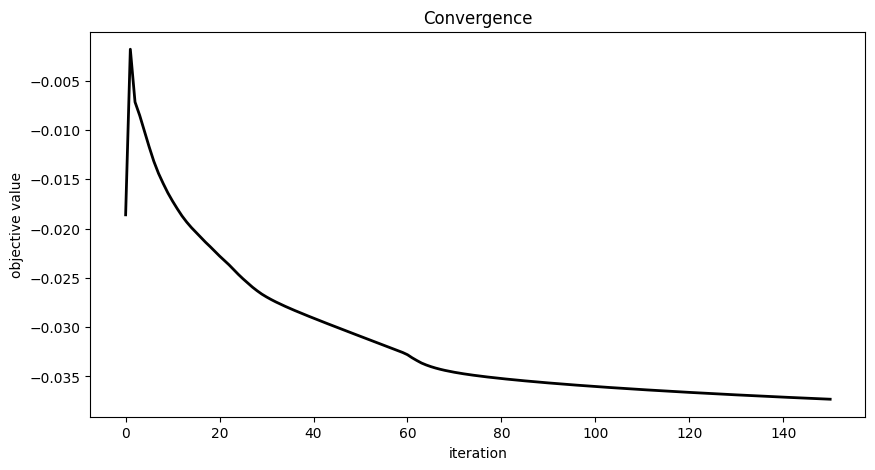

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(obj_value, lw=2, color='k')
plt.title('Convergence')
plt.xlabel('iteration')
plt.ylabel('objective value')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 2.1 Convergence for T={T_test}.jpg')

#Tracking Error

In [ ]:
train_error=(1/T_train)*np.linalg.norm(rb_train - X_train @ w_MM_single)**2
test_error=(1/T_test)*np.linalg.norm(rb_test - X_test @ w_MM_single)**2

In [ ]:
print(f"Train Error:{train_error}",train_error)
print(f"Test Error:{test_error}",test_error)

Train Error:0.00015774334837339942 0.00015774334837339942
Test Error:3.434173585573382e-05 3.434173585573382e-05


In [ ]:
returns_mm_train = X_train @ w_MM_single
returns_mm_test = X_test @ w_MM_single
rb_train=np.flip(rb_train)
rb_test=np.flip(rb_test)

In [ ]:
mm_PnL_train= np.array([1])
mm_PnL_test=np.array([1])
rb_PnL_train=np.array([1])
rb_PnL_test=np.array([1])
for i in returns_mm_train:
    mm_PnL_train = np.append(mm_PnL_train, mm_PnL_train[-1]*np.exp(i))
for i in returns_mm_test:
    mm_PnL_test = np.append(mm_PnL_test, mm_PnL_test[-1]*np.exp(i))
for i in rb_train:
    rb_PnL_train = np.append(rb_PnL_train, rb_PnL_train[-1]*np.exp(i))
for i in rb_test:
    rb_PnL_test = np.append(rb_PnL_test, rb_PnL_test[-1]*np.exp(i))


Plotting Tracked value vs Real value during training

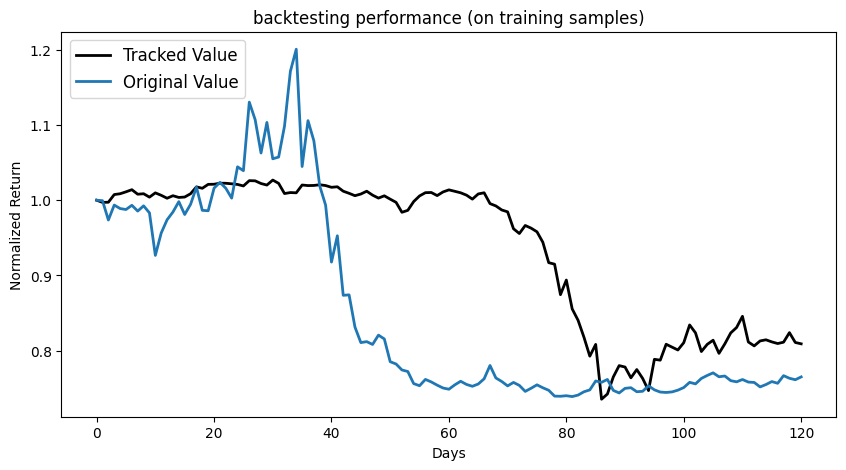

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(mm_PnL_train, label='Tracked Value', lw=2, color='k')
plt.plot(rb_PnL_train, label='Original Value', lw=2)

plt.legend(loc='upper left', fontsize=12)
plt.title('backtesting performance (on training samples)')
plt.xlabel('Days')
plt.ylabel('Normalized Return')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 2.1 Training for T={T_test}.jpg')

Plotting Tracked value vs Real value during testing

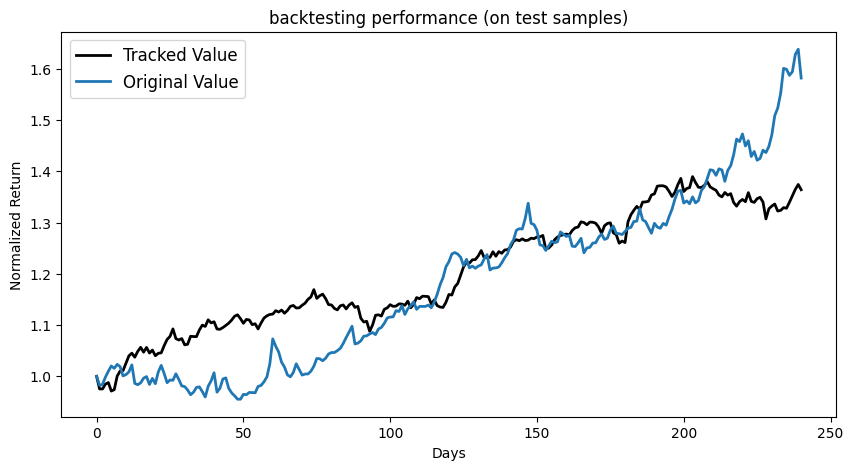

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(mm_PnL_test, label='Tracked Value', lw=2, color='k')
plt.plot(rb_PnL_test, label='Original Value', lw=2)

plt.legend(loc='upper left', fontsize=12)
plt.title('backtesting performance (on test samples)')
plt.xlabel('Days')
plt.ylabel('Normalized Return')
plt.savefig(f'/content/drive/MyDrive/NIFTY 50 Dataset/Plots/Model 2.1 Testing for T={T_test}.jpg')